In [17]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import missingno as msno
# eye candy plots
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')


warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('data/train_clinical_data.csv')

In [5]:
df.columns.to_list()

['visit_id',
 'patient_id',
 'visit_month',
 'updrs_1',
 'updrs_2',
 'updrs_3',
 'updrs_4',
 'upd23b_clinical_state_on_medication']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2615 non-null   object 
 1   patient_id                           2615 non-null   int64  
 2   visit_month                          2615 non-null   int64  
 3   updrs_1                              2614 non-null   float64
 4   updrs_2                              2613 non-null   float64
 5   updrs_3                              2590 non-null   float64
 6   updrs_4                              1577 non-null   float64
 7   upd23b_clinical_state_on_medication  1288 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 163.6+ KB


In [7]:
df.describe()

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
count,2615.000000,2615.000000,2614.000000,2613.00000,2590.000000,1577.000000
mean,32651.743786,31.190822,7.110559,6.74359,19.421236,1.861763
std,18535.758700,25.199053,5.525955,6.32323,15.000289,3.022112
min,55.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,16574.000000,10.500000,3.000000,1.00000,6.000000,0.000000
50%,29417.000000,24.000000,6.000000,5.00000,19.000000,0.000000
75%,50611.000000,48.000000,10.000000,10.00000,29.000000,3.000000
max,65043.000000,108.000000,33.000000,40.00000,86.000000,20.000000


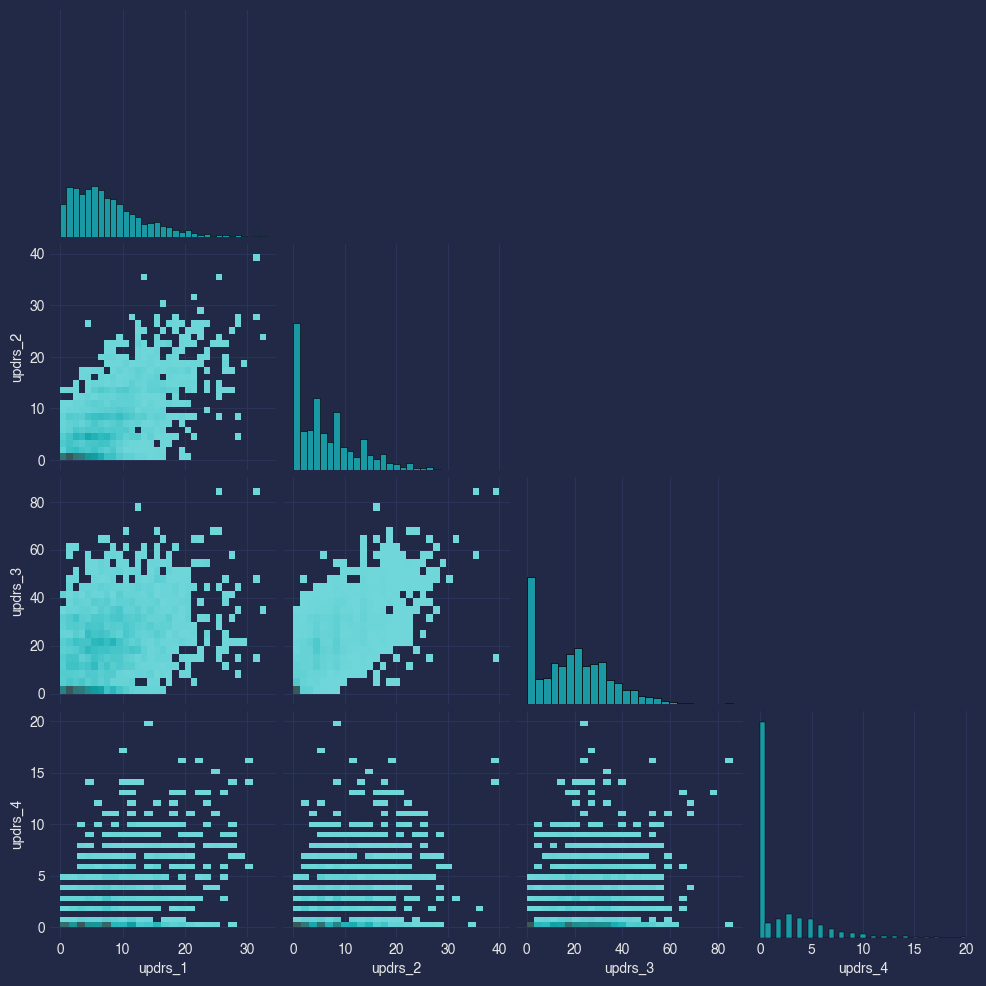

In [11]:
# colors=list(sns.color_palette('flare',n_colors=4).as_hex())
# hue_order = zip([10,20,25,30],colors)
# palette = dict(hue_order)

vars = ['updrs_1','updrs_2','updrs_3','updrs_4']
sns.pairplot(data=df,vars=vars,
             diag_kind='hist',corner=True, kind='hist',
             dropna=True);

<AxesSubplot:>

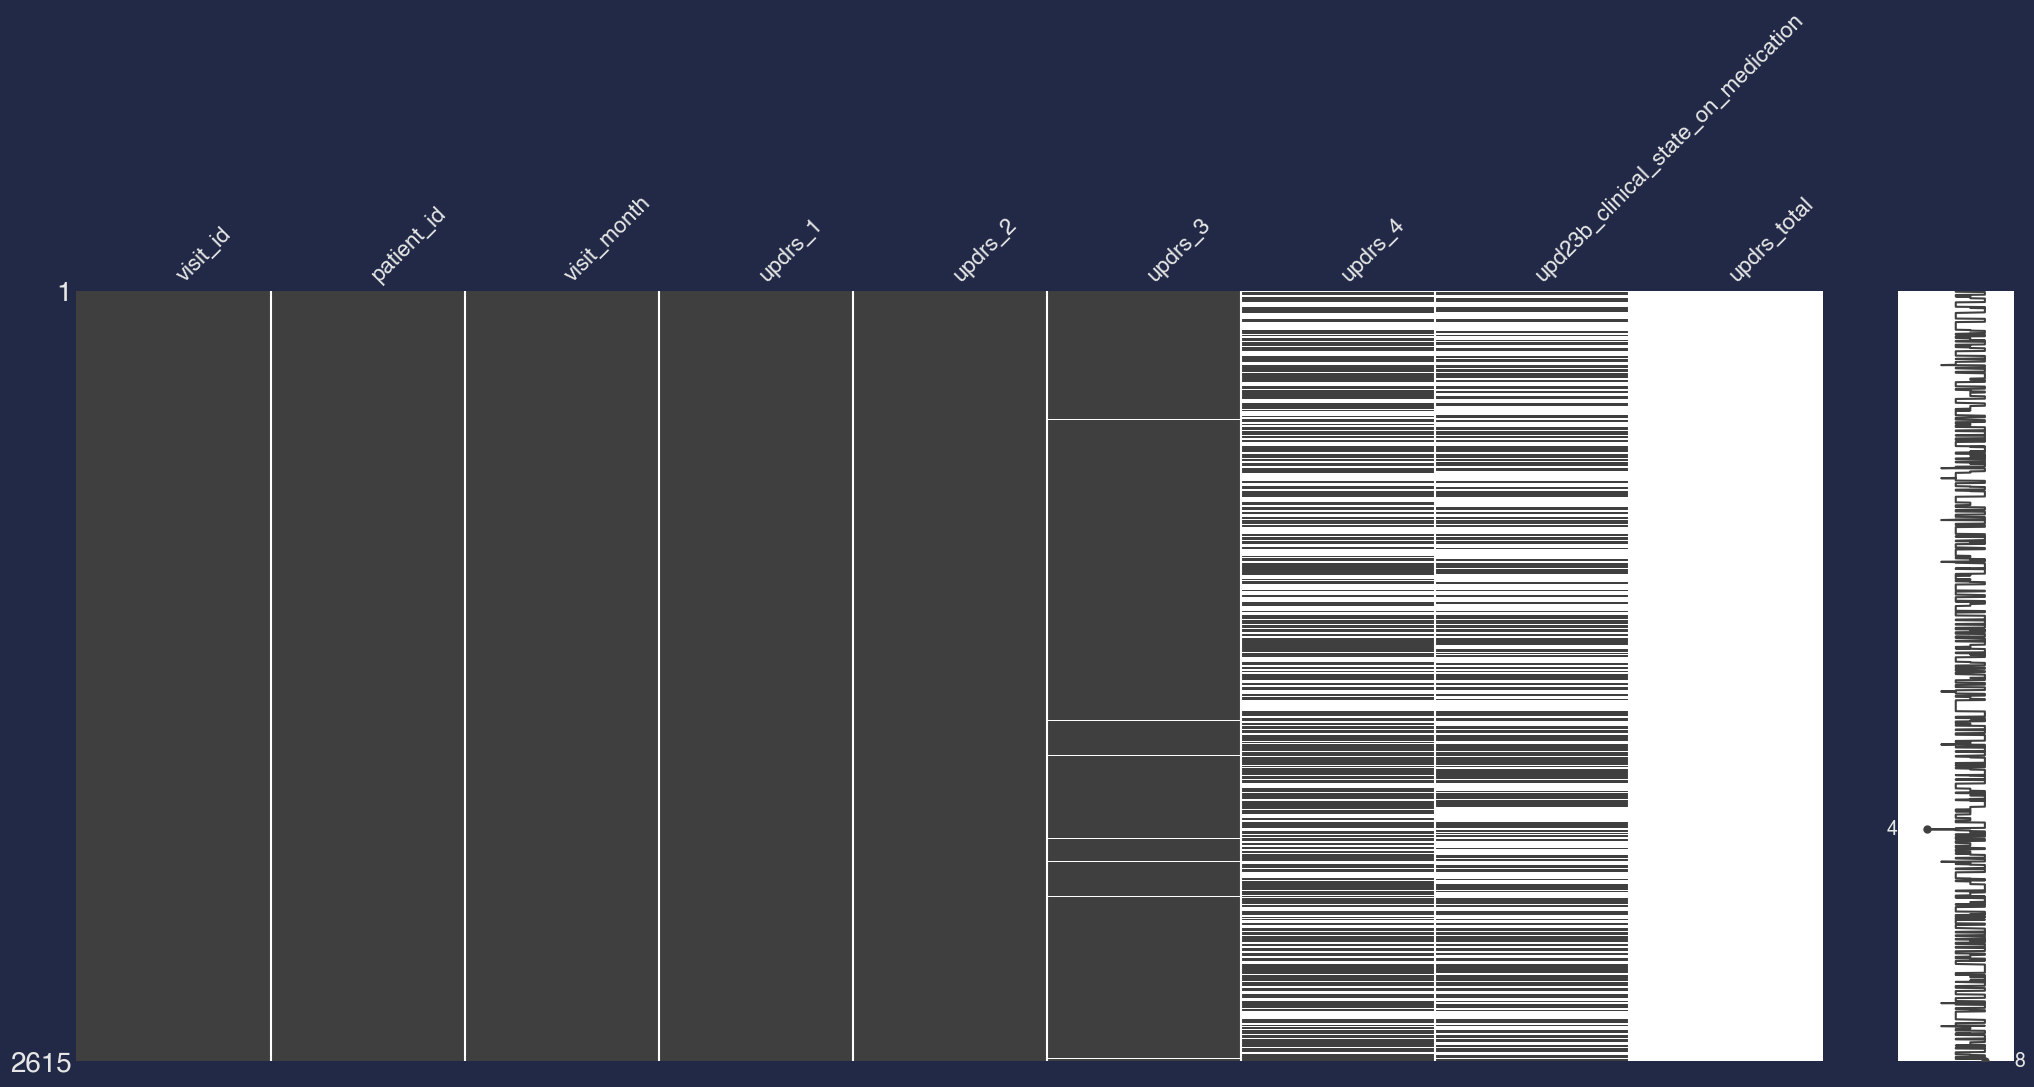

In [18]:
#missign values
msno.matrix(df)

In [7]:
df_proteins = pd.read_csv('train_proteins.csv')

In [8]:
df_proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [9]:
df_proteins_ = pd.pivot_table(data=df_proteins,values='NPX',columns='UniProt',index='visit_id',aggfunc='sum')
df_proteins_.shape

(1113, 227)

In [19]:
## Getting rid of Nans in UPDRS, which will not be needed for test, only train data


### Many records are likely patients who do not have parkinsons. 
# The mean total UPDRS score for the general popluation could be around 12.5 +- SD 9.5, according to 
# Mark R Keezer, Christina Wolfson, Ronald B Postuma (2016) https://pubmed.ncbi.nlm.nih.gov/26967747/

# Therefore, 

## Note, the total possible points for each section are encoded as comments below
# df['updrs_1_frc'] = df['updrs_1'] / (13*4)
# df['updrs_2_frc'] = df['updrs_2'] / (13*4)
# df['updrs_3_frc'] = df[['updrs_3']] / (33*4)
# df['updrs_4_frc'] = df[['updrs_4']] / (6*4)


2.95

In [40]:
df = pd.read_csv('data/train_clinical_data.csv')


### Keep track of NaNs
df['updrs_4_na'] = df.updrs_4.isna()
df['updrs4_allna'] = False
df['updrs_3_na'] = df.updrs_3.isna()

df['updrs_1to3'] = df[['updrs_1','updrs_2','updrs_3']].sum(axis=1)


## Test hypothesis that low UPDRS I-III scores imply low UPDRS IV score

print("Distribution of UPDRS IV values for those records with sum of UPDRS I-III less than 15")
print(df[df['updrs_1to3']<=15].updrs_4.fillna('nan').value_counts())


Distribution of UPDRS IV values for those records with sum of UPDRS I-III less than 20
nan    529
0.0    179
4.0      7
1.0      3
3.0      2
2.0      2
5.0      2
Name: updrs_4, dtype: int64


* A minority of records have UPDRS I-III < 15 and a non-zero UPDRS IV. 
* Set all records with NaNs in IV to 0 if sum of I-III is less than 15

In [41]:

## If sum of all updrs from 1 to 3 is less than 3, then fill with updrs 4 with zeros
condition = (df['updrs_1to3']<=15) & df.updrs_4_na
df.updrs_4 = np.where(condition, 0., df.updrs_4)


### Fill remaining updrs_4 using forward and backfill
for patient in df.patient_id.unique():
    condition = (df.patient_id == patient)
    df.loc[condition,'updrs_4'] = df.loc[condition,'updrs_4'].fillna(method='ffill')
    df.loc[condition,'updrs_4'] = df.loc[condition,'updrs_4'].fillna(method='bfill')
    #Check if all a patient's updrs_4 records are 0, so that back and forward fill are of no use
    if df.loc[condition,'updrs_4'].isna().all():
        df.loc[condition,'updrs4_allna'] = True
    #print(df.loc[condition,['updrs_4','updrs_4_na']])


## Interpolate updrs_3
# Taking care not to cross boundaries between patients
# Respect conditions of up23d, whether on medication or not
#printvars= ['patient_id','visit_month','updrs_3','upd23b_clinical_state_on_medication']
for patient in df.patient_id.unique():
    condition = (df.patient_id == patient)
    if df.loc[condition,'updrs_3_na'].any():
        imax = len(df.loc[condition])
        for ii in range(1,imax+1):
                row = df.loc[condition][ii-1:ii]
                if (row['updrs_3_na'].values):
                    if (row['upd23b_clinical_state_on_medication'].isna().all()):
                        
                        df.loc[condition,'updrs_3'] = df.loc[condition,'updrs_3'].interpolate(limit_direction='both')
                        
                    else:
                        new_condition = condition & (df['upd23b_clinical_state_on_medication'] == row['upd23b_clinical_state_on_medication'].values[0]) 
                        
                        df.loc[new_condition,'updrs_3'] = df.loc[new_condition,'updrs_3'].interpolate(limit_direction='both')


## Interpolate the two remaining missing values updrs_2                       
#printvars= ['patient_id','visit_month','updrs_1','updrs_2','updrs_3','upd23b_clinical_state_on_medication']
for patient in df.patient_id.unique():
    condition = (df.patient_id == patient)
    if (df.loc[condition,['updrs_1','updrs_2']].isna().values.any()):
            df.loc[condition,['updrs_1','updrs_2']] = df.loc[condition,['updrs_1','updrs_2']].interpolate(
                  limit_direction='both',axis=0
            )

## Ensure that interpolation has not caused fractional values
for col in ['updrs_1','updrs_2','updrs_3','updrs_4']:
    df[col] = round(df[col])

<AxesSubplot:>

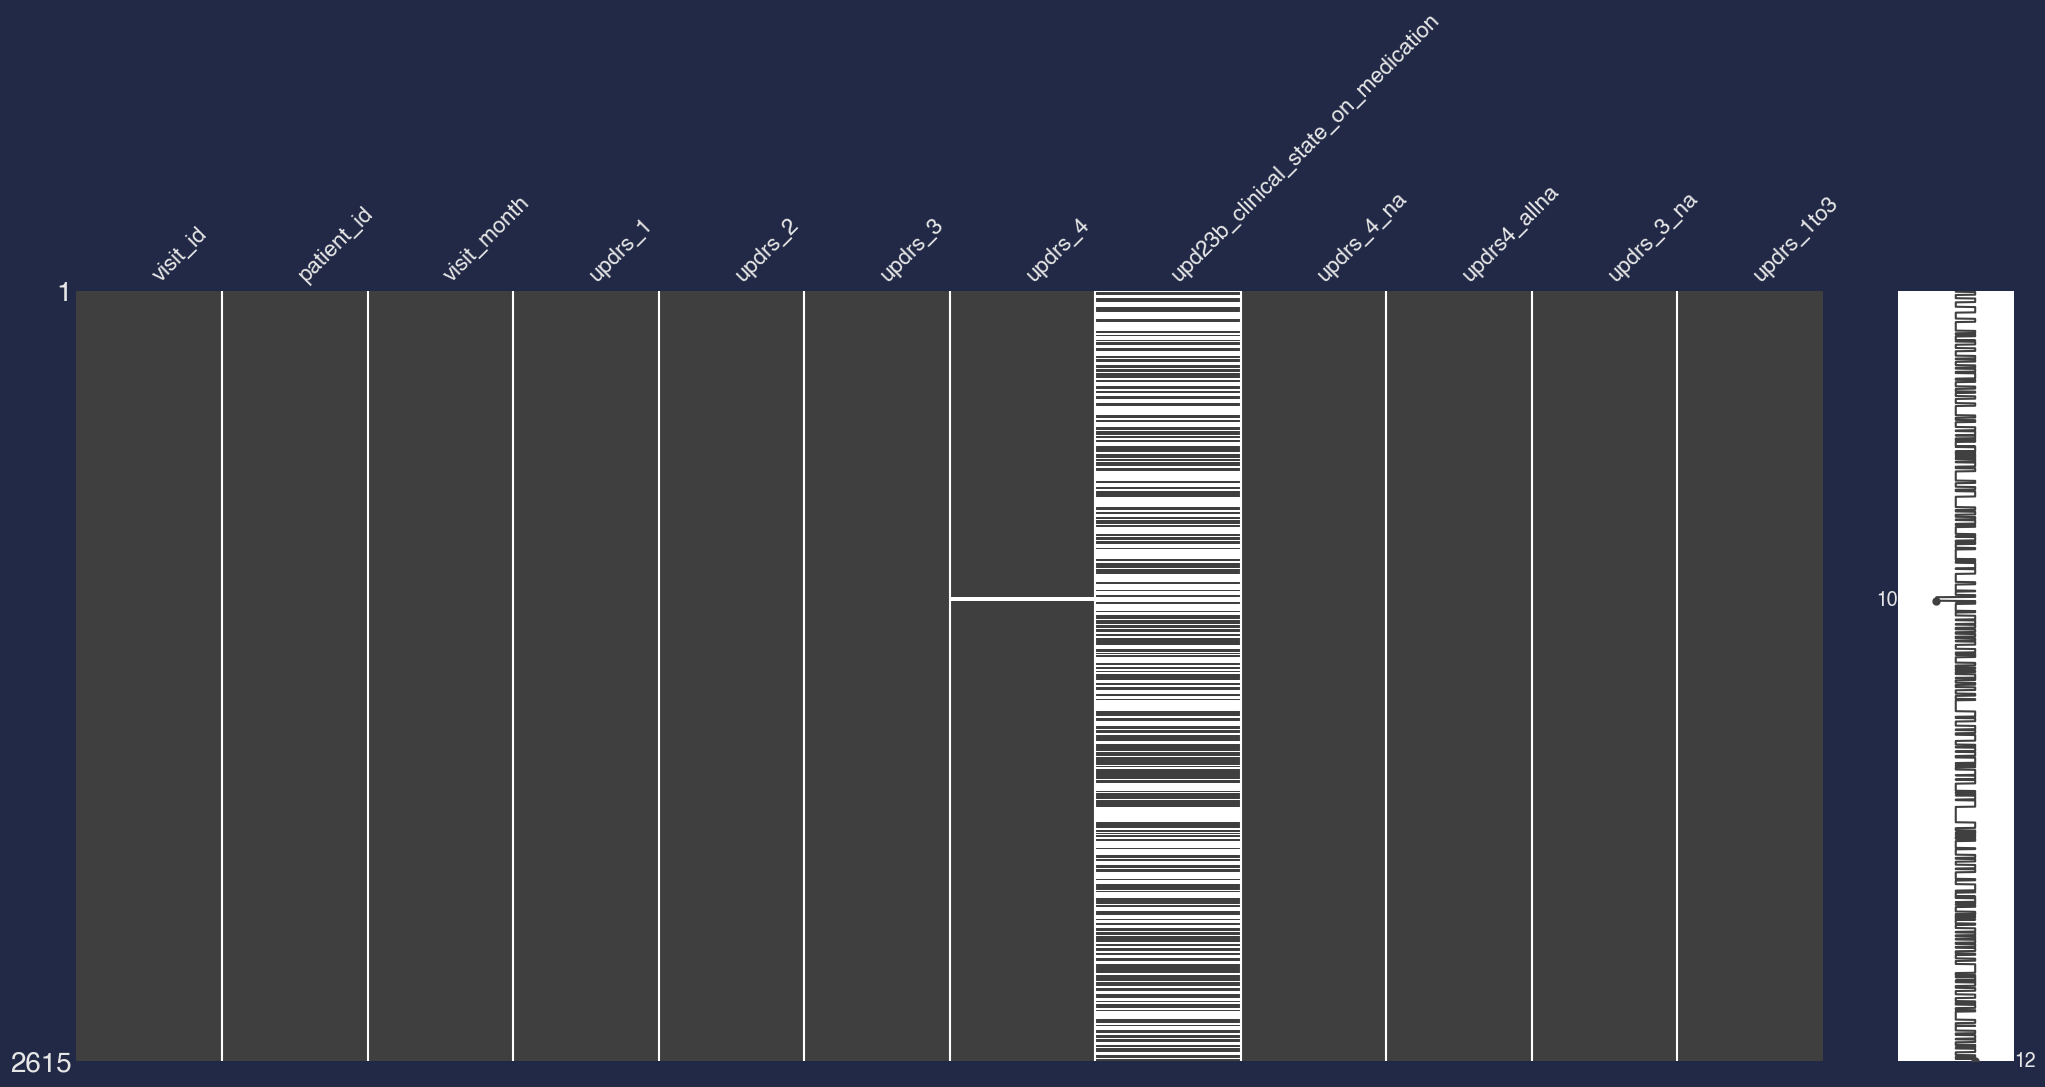

In [42]:
#missign values
msno.matrix(df)

In [43]:
## Which patient records still have NaNs for UPDRS_4?
df[df.updrs_4.isna()]

# A single patient with id 24911 should be discarded from the analysis

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,updrs_4_na,updrs4_allna,updrs_3_na,updrs_1to3
1039,24911_0,24911,0,9.0,7.0,14.0,NaN,NaN,True,True,False,30.0
1040,24911_3,24911,3,4.0,6.0,13.0,NaN,NaN,True,True,False,23.0
1041,24911_6,24911,6,5.0,6.0,14.0,NaN,NaN,True,True,False,25.0
1042,24911_9,24911,9,7.0,7.0,7.0,NaN,NaN,True,True,False,21.0
1043,24911_12,24911,12,11.0,5.0,26.0,NaN,NaN,True,True,False,42.0
1044,24911_18,24911,18,9.0,4.0,16.0,NaN,NaN,True,True,False,29.0
1045,24911_24,24911,24,11.0,8.0,19.0,NaN,NaN,True,True,False,38.0
1046,24911_30,24911,30,10.0,5.0,18.0,NaN,NaN,True,True,False,33.0
1047,24911_36,24911,36,10.0,6.0,20.0,NaN,NaN,True,True,False,36.0
1048,24911_42,24911,42,10.0,6.0,17.0,NaN,NaN,True,True,False,33.0


In [44]:
df.drop(df[df.patient_id == 24911].index, inplace=True)

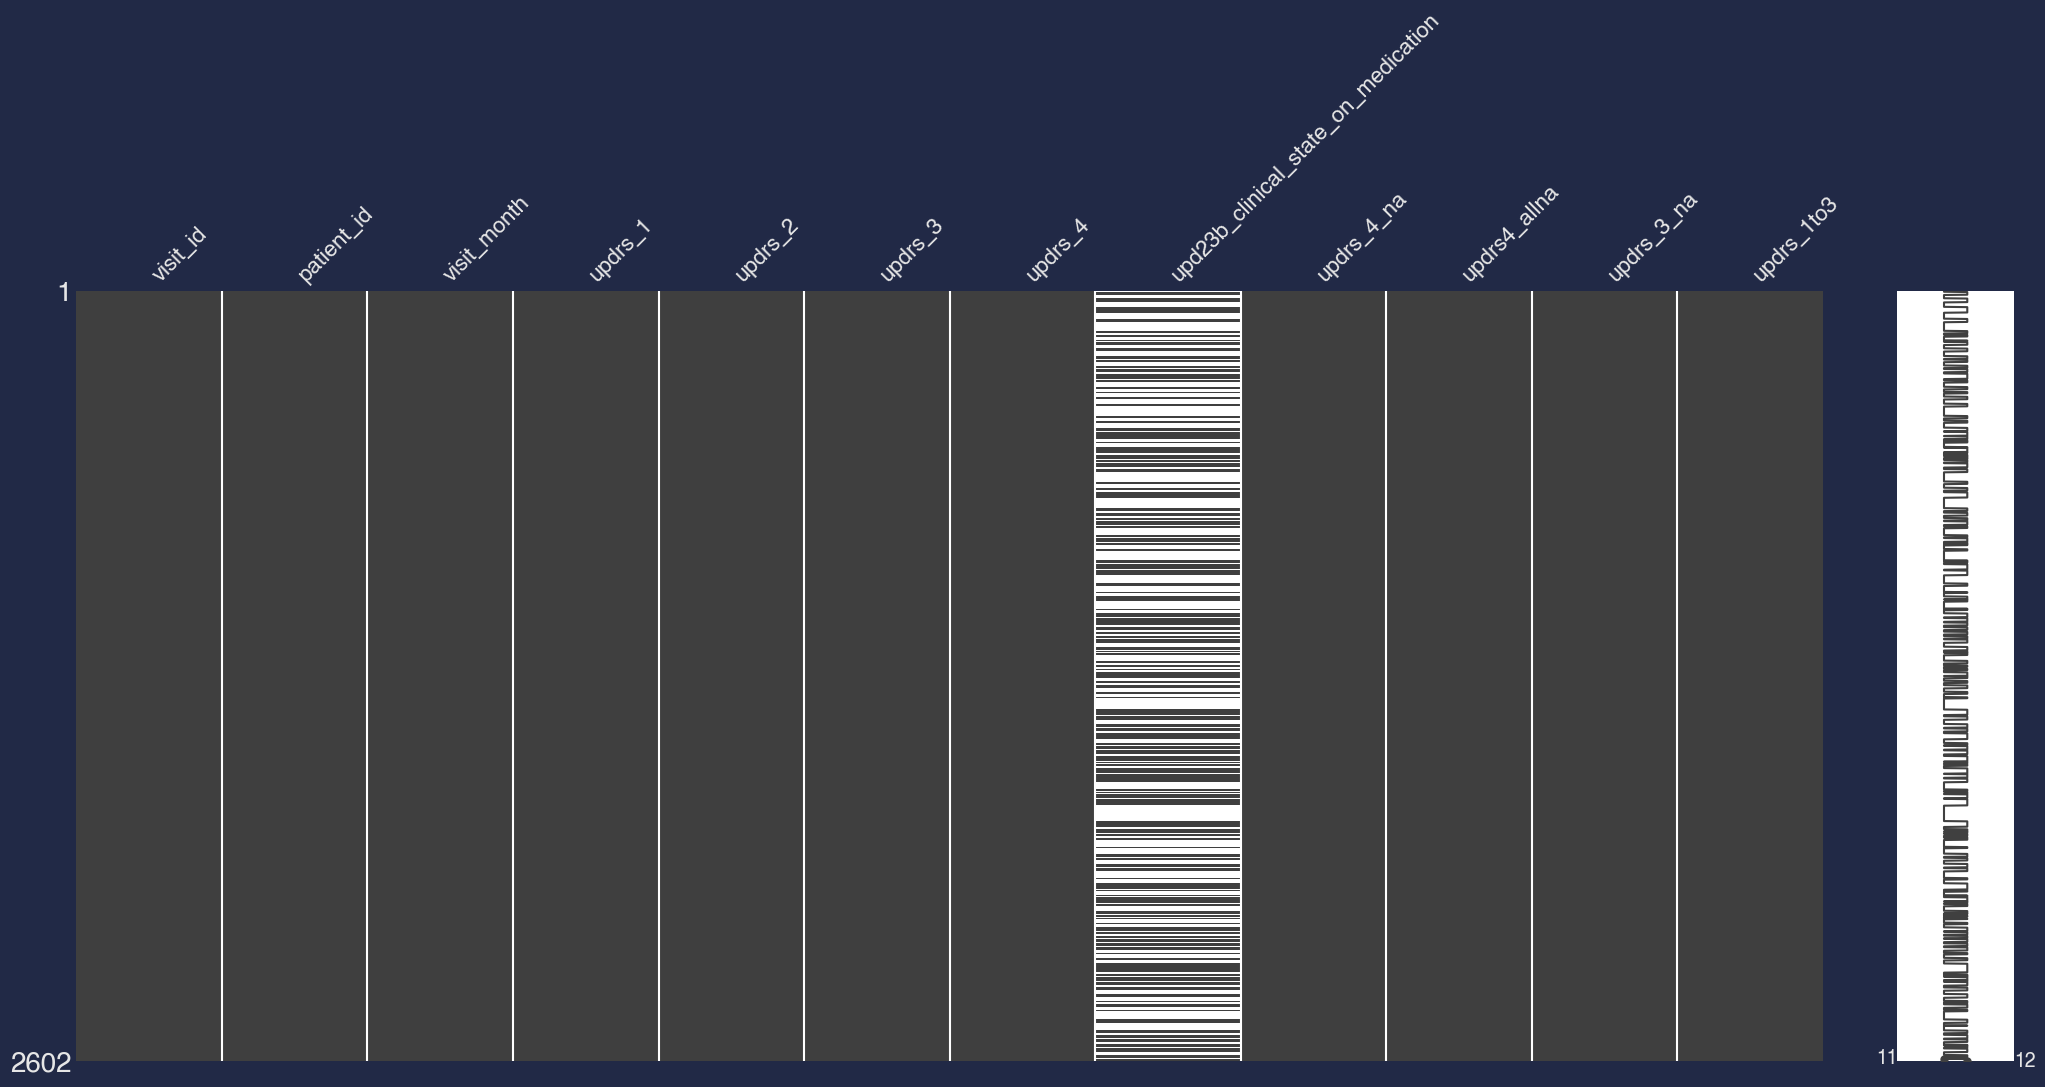

In [47]:
msno.matrix(df);

### Time differencing

In [12]:
### calculate time differencing with step = 1
updrs = ['updrs_1','updrs_2','updrs_3','updrs_4']


for col in updrs:
    for tt in [-1,-2,-4]:
        name = col+'_d' + str(abs(tt)) # name of shift column
        df[name] = np.nan         # fill with nans
        for patient in df.patient_id.unique():
            pid = df.patient_id == patient # for specific patient
            df_pi = df.loc[pid]
            df_shf = df.loc[pid].shift(tt) # shift patient DF
            df.loc[pid,name] = ((df_shf[col] - df_pi[col] ) 
                                      * 12 
                                      / (df_shf.visit_month - df_pi.visit_month))
        



 ### Peptides

In [39]:
## Peptide join
df_peptides = pd.read_csv('train_peptides.csv')
df_peptides_ = pd.pivot_table(df_peptides,index='visit_id',
                              columns='Peptide',
                              values='PeptideAbundance')

df_peptides_.shape
df_peptides_.fillna(0,inplace=True)

####
df_peptides_bin = df_peptides_ > 0
peptides = df_peptides_bin.columns



## Print numbers of records
print(df_peptides.visit_id.nunique(), df_proteins.visit_id.nunique(), df.visit_id.nunique())
no_measurements = set(df.visit_id.unique()) - set(df_peptides.visit_id.unique())
no_measurements = sorted(list(no_measurements))

df_full_pep = df.join(df_peptides_bin, on="visit_id",how='inner')
df_full_pep_ = df.join(df_peptides_, on="visit_id",how='inner')



1113 1113 2615


In [40]:
df_full_pep

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,updrs_4_na,updrs4_allna,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,55_0,55,0,0.192308,0.115385,0.113636,0.000000,NaN,True,False,...,True,True,True,True,True,True,True,True,True,True
2,55_6,55,6,0.153846,0.192308,0.257576,0.000000,NaN,True,False,...,True,True,True,True,True,True,True,True,True,True
4,55_12,55,12,0.192308,0.192308,0.310606,0.000000,On,False,False,...,True,True,True,True,True,True,True,True,True,True
8,55_36,55,36,0.326923,0.346154,0.386364,0.000000,On,False,False,...,True,True,True,True,True,True,True,True,True,True
15,942_6,942,6,0.153846,0.038462,0.159091,0.000000,NaN,True,False,...,True,True,False,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598,64674_84,64674,84,0.211538,0.288462,0.340909,0.166667,Off,False,False,...,True,True,True,True,True,True,True,True,True,True
2600,65043_0,65043,0,0.038462,0.115385,0.121212,0.000000,NaN,True,False,...,True,True,True,True,True,True,True,True,True,True
2604,65043_12,65043,12,0.076923,0.134615,0.106061,0.000000,Off,False,False,...,True,True,True,True,True,True,True,True,True,True
2606,65043_24,65043,24,0.076923,0.153846,0.060606,0.000000,NaN,False,False,...,True,True,True,True,True,True,True,True,True,True


In [14]:
pep_mean_dif = {}
num = []
keep = ['updrs_1','updrs_2','updrs_3','updrs_4','updrs_1_d1','updrs_2_d1','updrs_3_d1','updrs_4_d1']
for pep in peptides:
    condition = df_full_pep[pep]
    num.append(condition.sum())
    
    mean_pep = df_full_pep.loc[condition,keep].mean()
   
    #print(mean_pep)
    mean_nonpep = df_full_pep.loc[~condition,keep].mean()
    #print(mean_nonpep)
    pep_mean_dif[pep] = (mean_pep - mean_nonpep).values
    


pep_mean_dif = pd.DataFrame.from_dict(pep_mean_dif, orient='index', columns=keep)
#print(df_full_pep[keep].mean().abs() )
pep_mean_dif = pep_mean_dif * 100/ df_full_pep[keep].mean().abs()
pep_mean_dif['numrec_with'] = num


In [159]:

pep_mean_dif = pep_mean_dif.abs().sort_values(['updrs_3_d1','updrs_2_d1','updrs_1_d1','updrs_4_d1'])
#pep_mean_dif.sort_values(by='updrs_3',ascending=False)


In [198]:
common_peps = pep_mean_dif[pep_mean_dif['numrec_with'] > 1060].sort_values(by='numrec_with', ascending=False).index

In [225]:
keep = ['updrs_1','updrs_2','updrs_3','updrs_4']
# keep = ['updrs_1_d1','updrs_2_d1','updrs_3_d1','updrs_4_d1']
vars_int = list(common_peps) + keep

# df_full_pep_[vars_int]

correlations = df_full_pep_[vars_int].corr()
correlations.drop(common_peps, axis=1,inplace=True)
correlations.drop(keep, axis=0,inplace=True)
common_max_correlation = correlations.abs().max(axis=1)

In [232]:
keep = ['updrs_1','updrs_2','updrs_3','updrs_4']
# keep = ['updrs_1_d1','updrs_2_d1','updrs_3_d1','updrs_4_d1']
vars_int = list(peptides) + keep

# df_full_pep_[vars_int]

correlations = df_full_pep_[vars_int].corr()
correlations.drop(peptides, axis=1,inplace=True)
correlations.drop(keep, axis=0,inplace=True)
all_max_correlation = correlations.abs().max(axis=1)

lowest_first = all_max_correlation.sort_values(axis=0)


<AxesSubplot:ylabel='Density'>

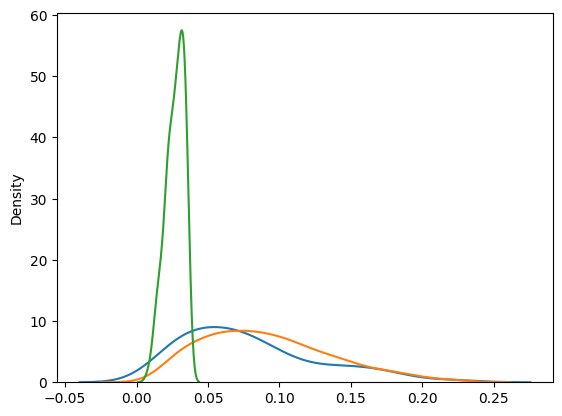

In [233]:
sns.kdeplot(common_max_correlation)
sns.kdeplot(all_max_correlation)
sns.kdeplot(lowest_first[:100])


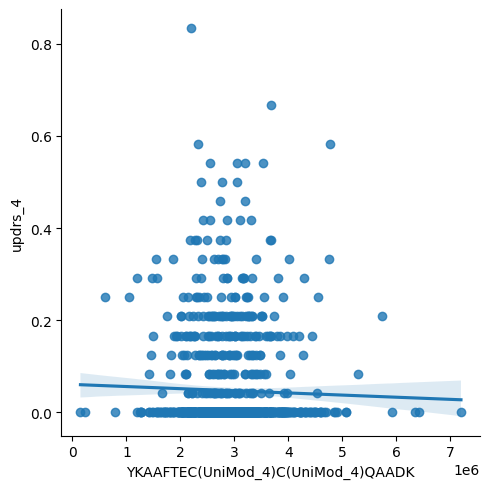

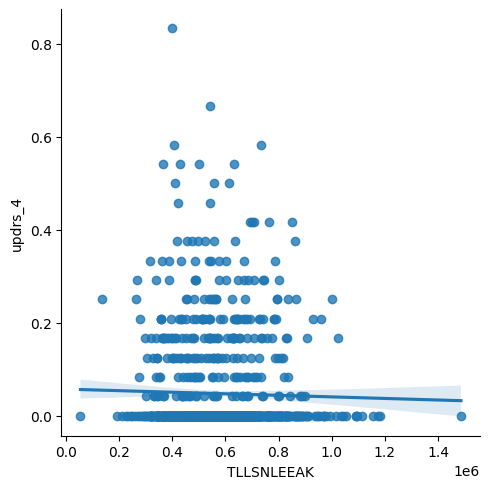

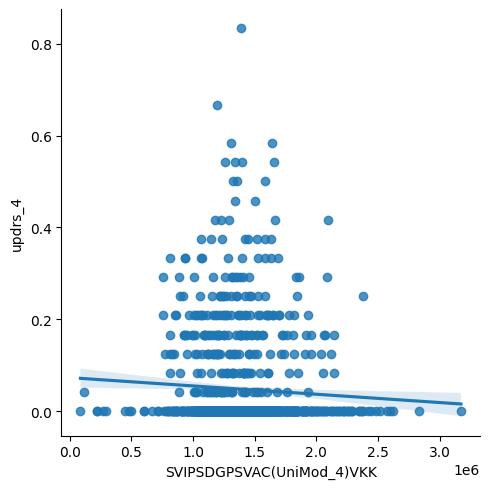

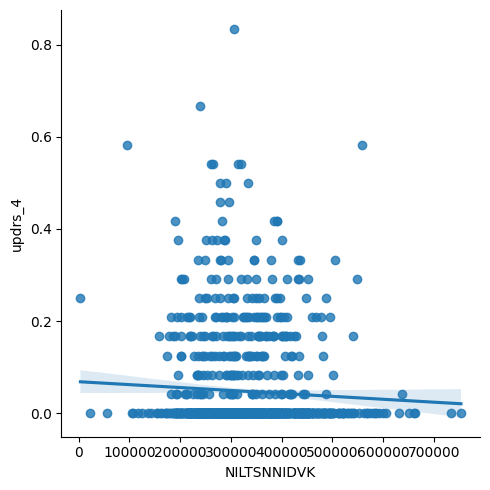

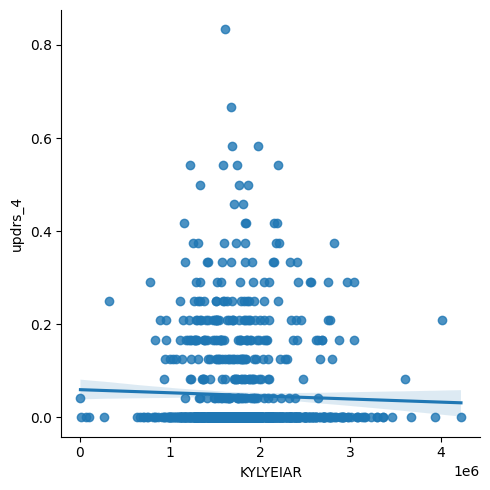

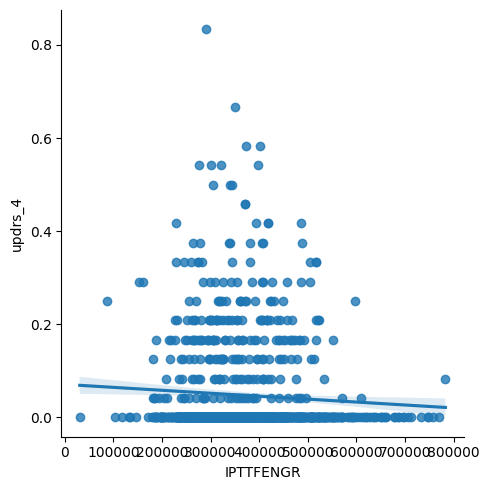

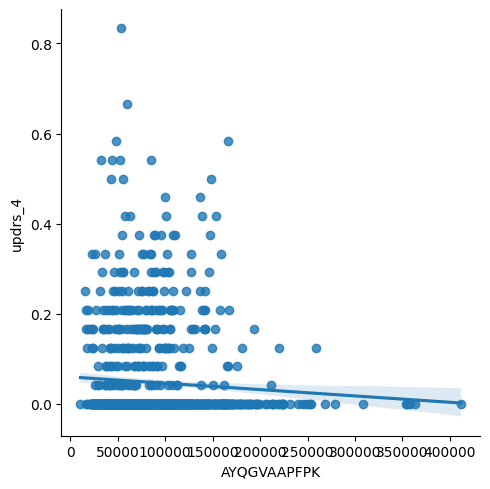

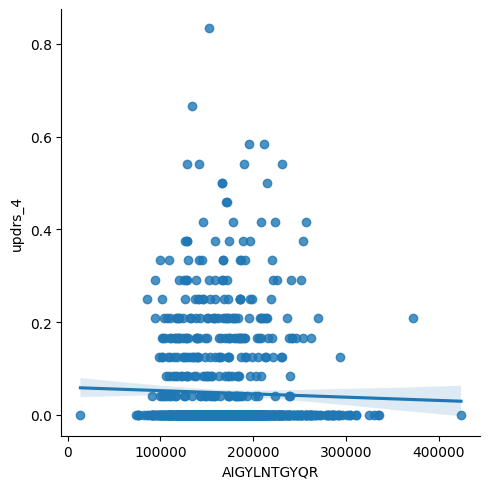

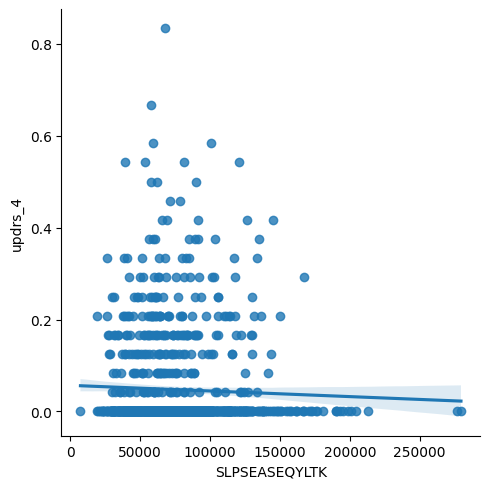

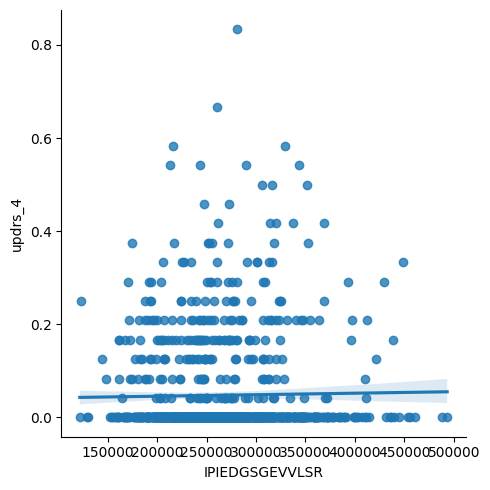

In [187]:
keep = ['updrs_1','updrs_2','updrs_3','updrs_4']
for pep in common_peps[:10]:
    dff = df_full_pep_[df_full_pep_[pep] > 0.]
    sns.lmplot(data=dff,x=pep,y=keep[3])

In [16]:
pep_mean_dif

,updrs_1,updrs_2,updrs_3,updrs_4,updrs_1_d1,updrs_2_d1,updrs_3_d1,updrs_4_d1,numrec_with
AADDTWEPFASGK,13.047929,5.124184,-3.174525,-8.654510,-517.657483,-71.248603,-145.539481,221.259161,1025
AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,6.898681,12.721480,14.985941,-19.242990,140.892023,-5.331501,-478.263596,-209.620495,1004
AAFTEC(UniMod_4)C(UniMod_4)QAADK,30.088103,52.143749,49.459579,100.478469,-108.101609,79.019561,-277.328578,-300.314056,1063
AANEVSSADVK,0.581890,-8.670728,-10.916714,8.217077,84.584368,102.757442,173.812753,43.571122,870
AATGEC(UniMod_4)TATVGKR,-4.664491,-7.127152,-9.715109,5.616144,98.189467,65.062097,-11.704460,-253.827618,876
...,...,...,...,...,...,...,...,...,...
YVNKEIQNAVNGVK,31.529170,91.582150,68.395598,100.190840,1140.080969,-221.146185,-841.518037,100.206186,1066
YWGVASFLQK,1.373037,13.653621,0.934505,20.217277,213.247334,91.767635,-867.180244,-795.426907,1045
YYC(UniMod_4)FQGNQFLR,24.035740,59.647376,39.717312,-9.908126,-466.666814,-206.891945,-386.066612,817.978705,1060
YYTYLIMNK,-31.418003,-22.819160,-2.136716,-84.299186,123.771475,-82.530548,-23.219791,115.393826,988


In [17]:
df.tail(20)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,updrs_4_na,updrs4_allna,...,updrs_1_d4,updrs_2_d1,updrs_2_d2,updrs_2_d4,updrs_3_d1,updrs_3_d2,updrs_3_d4,updrs_4_d1,updrs_4_d2,updrs_4_d4
2595,64674_54,64674,54,0.173077,0.269231,0.431818,0.125000,On,False,False,...,0.005495,-0.038462,-0.012821,0.027473,-0.181818,-0.020202,0.006494,0.000000,0.027778,0.035714
2596,64674_60,64674,60,0.269231,0.250000,0.340909,0.125000,Off,False,False,...,NaN,0.000000,0.019231,NaN,0.060606,0.000000,NaN,0.041667,0.020833,NaN
2597,64674_72,64674,72,0.192308,0.250000,0.401515,0.166667,Off,False,False,...,NaN,0.038462,0.057692,NaN,-0.060606,0.026515,NaN,0.000000,0.041667,NaN
2598,64674_84,64674,84,0.211538,0.288462,0.340909,0.166667,Off,False,False,...,NaN,0.076923,NaN,NaN,0.113636,NaN,NaN,0.083333,NaN,NaN
2599,64674_96,64674,96,0.192308,0.365385,0.454545,0.250000,Off,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2600,65043_0,65043,0,0.038462,0.115385,0.121212,0.000000,NaN,True,False,...,0.038462,0.384615,0.000000,0.019231,0.090909,0.045455,-0.015152,0.000000,0.000000,0.000000
2601,65043_3,65043,3,0.038462,0.211538,0.143939,0.000000,NaN,True,False,...,0.061538,-0.384615,-0.153846,-0.061538,0.000000,-0.121212,-0.036364,0.000000,0.000000,0.000000
2602,65043_6,65043,6,0.057692,0.115385,0.143939,0.000000,NaN,True,False,...,0.012821,0.076923,0.038462,0.025641,-0.242424,-0.075758,-0.055556,0.000000,0.000000,0.000000
2603,65043_9,65043,9,0.038462,0.134615,0.083333,0.000000,On,False,False,...,0.010989,0.000000,0.000000,-0.032967,0.090909,0.020202,-0.030303,0.000000,0.000000,0.000000
2604,65043_12,65043,12,0.076923,0.134615,0.106061,0.000000,Off,False,False,...,-0.019231,0.000000,0.019231,0.000000,-0.015152,-0.045455,-0.034091,0.000000,0.000000,0.000000


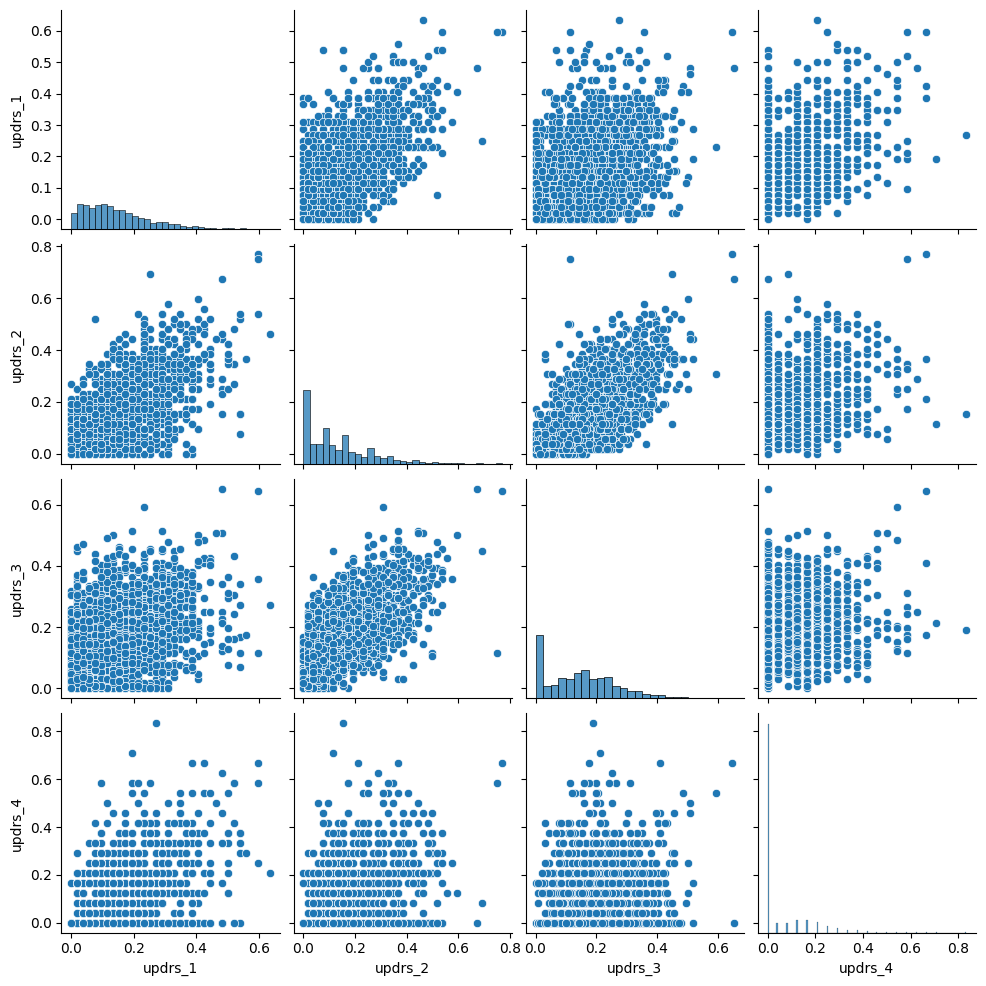

In [18]:
#colors=list(sns.color_palette('flare',n_colors=4).as_hex())
#hue_order = zip([10,20,25,30],colors)
#palette = dict(hue_order)

vars = ['updrs_1','updrs_2','updrs_3','updrs_4']
sns.pairplot(data=df,vars=vars,
             diag_kind='hist',corner=False, kind='scatter',
             dropna=False);#

In [31]:
df_patient = df.drop('upd23b_clinical_state_on_medication',axis=1).groupby('patient_id').max()
df_patient['updrs_4_max0'] = df_patient['updrs_4'] == 0
df_patient['updrs_3_max0'] = df_patient['updrs_3'] == 0
df_patient['updrs_3to4_max0'] = (df_patient['updrs_4'] == 0) & (df_patient['updrs_3'] == 0)

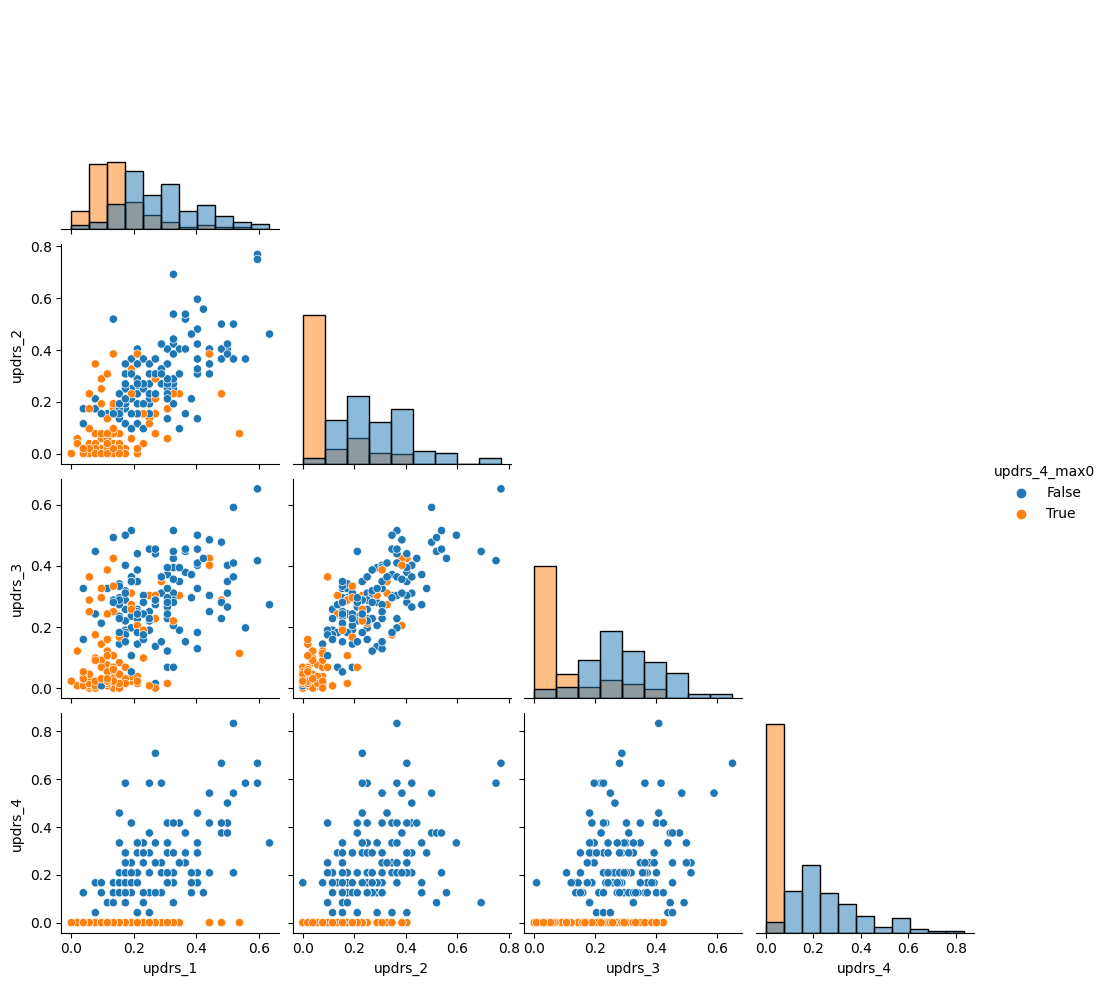

In [34]:
sns.pairplot(df_patient,vars=updrs,corner=True, hue='updrs_4_max0',diag_kind='hist')

In [109]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

In [155]:
peptide_feat = list(set(df_full_pep_.columns) - set(df.columns))

X = df_full_pep_[peptide_feat]
y = df_full_pep_['updrs_4']
dropna = y.isna()

X = X[~dropna]
y = y[~dropna]

X_train,X_test,y_train,y_test = train_test_split(X,y)

scaler = StandardScaler(with_mean=True)

X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

pca = TruncatedSVD(n_components=100)

X_train_scale_pca = pca.fit_transform(X_train_scale)
X_test_scale_pca =  pca.transform(X_test_scale)



In [156]:

model_lr = Ridge(alpha=0)
model_lr.fit(X_train_scale_pca,y_train)
y_pred_train = model_lr.predict(X_train_scale_pca)
y_pred_test = model_lr.predict(X_test_scale_pca)
print(r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test))

0.2761267332929701 0.0567793205162086


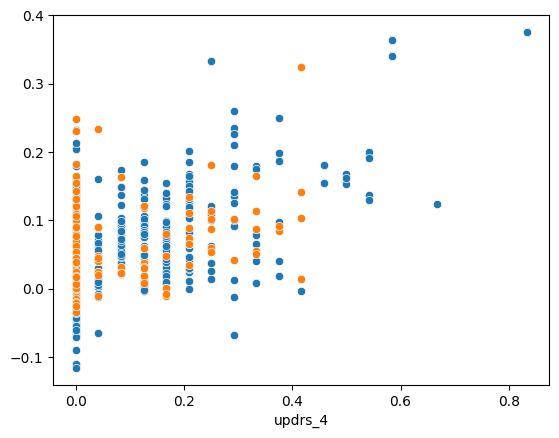

In [157]:
sns.scatterplot(x=y_train,y=y_pred_train);
sns.scatterplot(x=y_test,y=y_pred_test);

In [88]:
### Co-correlations amongst peptides

correlations = X.corr()
correlations[correlations < 0.5] = 0
correlations = correlations - np.diag(np.diag(correlations))


In [90]:
correlations.max(axis=1)

LADGGATNQGRVEIFYR                 0.523646
VVEQMC(UniMod_4)ITQYER            0.751310
TFTLLDPK                          0.000000
IVSSAM(UniMod_35)EPDREYHFGQAVR    0.000000
FVEGLPINDFSR                      0.702951
                                    ...   
LEPGQQEEYYR                       0.000000
ITYGETGGNSPVQEFTVPGSK             0.540741
TMQALPYSTVGNSNNYLHLSVLR           0.767379
GAYPLSIEPIGVR                     0.644173
IQPSGGTNINEALLR                   0.662239
Length: 968, dtype: float64

<AxesSubplot:>

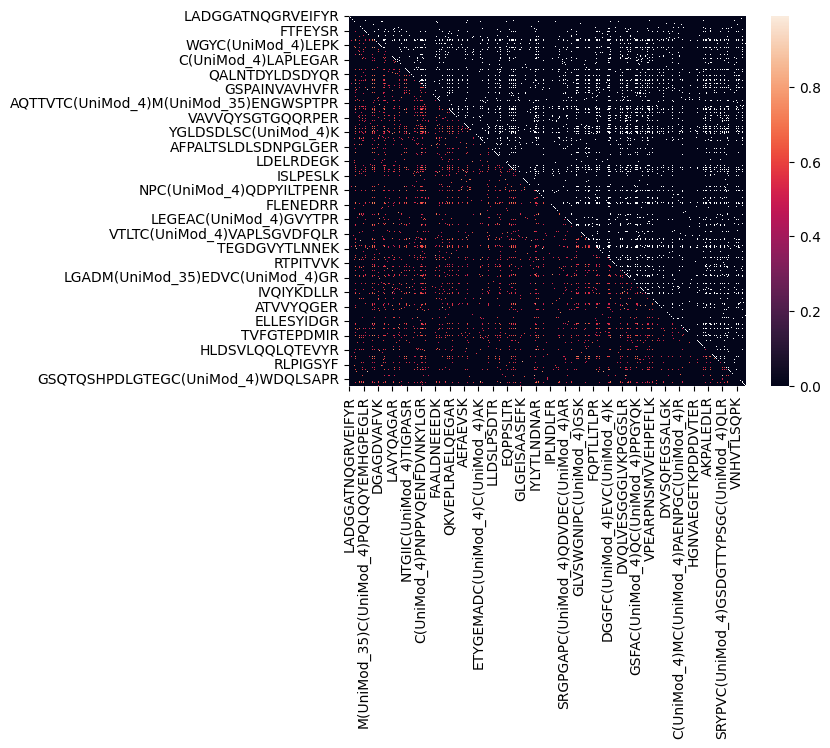

In [84]:

mask = np.triu(correlations)
sns.heatmap(correlations,mask=mask,cmap=)